In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import torch
import numpy as np

import defmod as dm
import multimodule_usefulfunctions as mm 
import matplotlib.pyplot as plt
import defmod.hamiltonian_multishape as hamiltonian
import model_graddesc as model
import defmod.registrationdata as regdata
import scipy.optimize

torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
data = regdata.organs()
data.build_modules()
data()
source = data.source
target = data.target

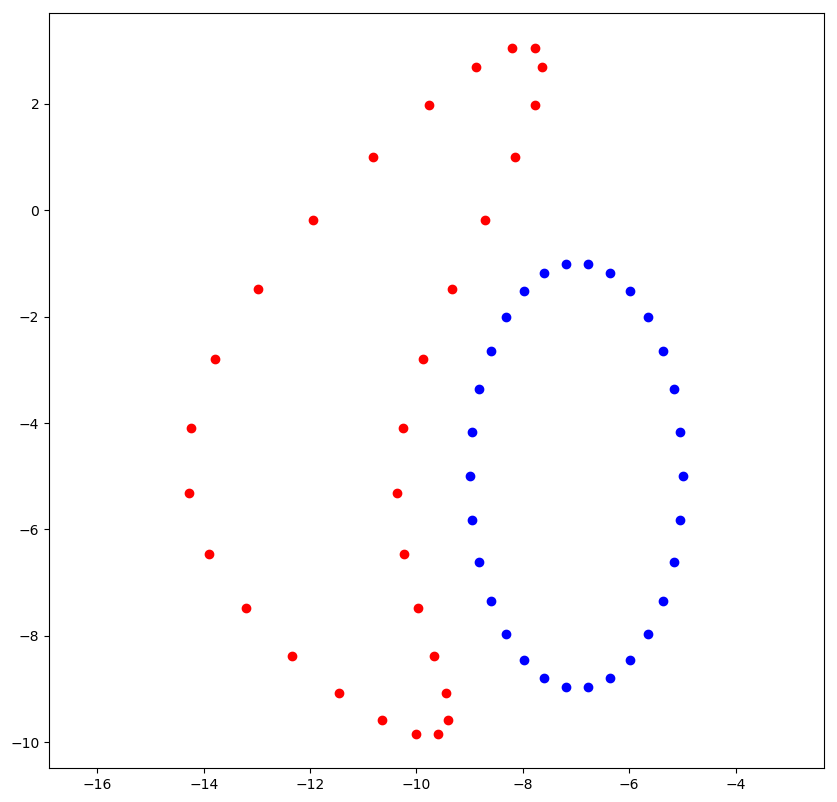

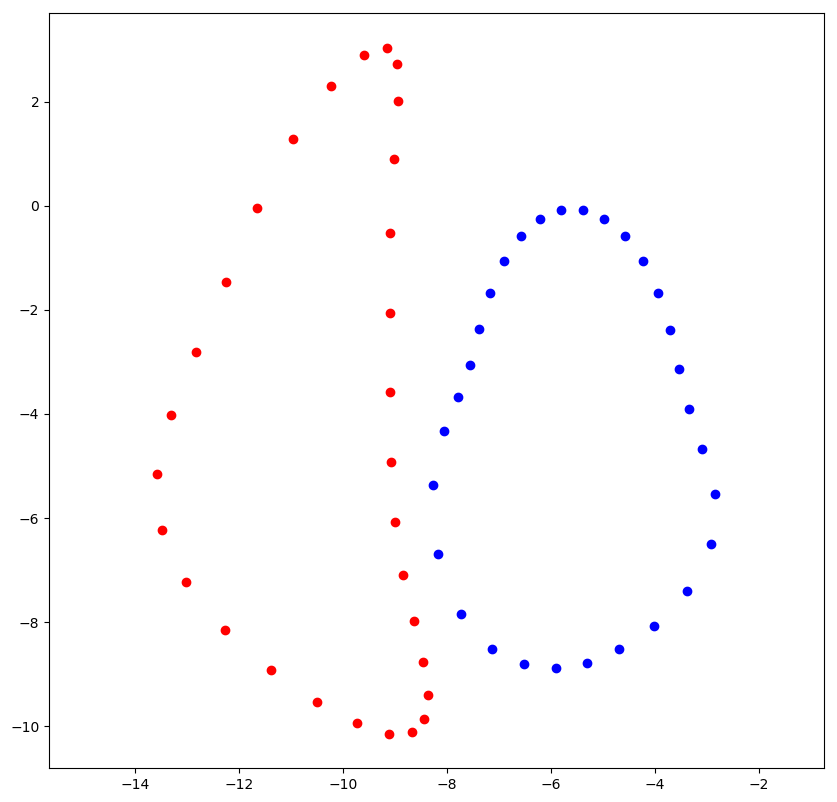

In [3]:
fig_source = plt.figure(figsize = (10,10), dpi=100)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')
plt.axis('equal')

fig_target = plt.figure(figsize = (10,10), dpi=100)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [4]:
modules = dm.multishape.MultiShapeModule([data.modules[0], data.modules[1]], 0.5, reduce_background=True)
modules.fill_controls_zero()
#constr_Id = dm.constraints.Identity_Silent()
constr_Id = dm.constraints.Identity_Silent_reduced()
H = hamiltonian.Hamiltonian_multi(modules, constr_Id)

In [7]:
# set parameters
reg_param = 10**-3 

gd0_tensor = torch.cat(H.module.manifold.unroll_gd().copy(),0).requires_grad_().view(-1)
mom0_tensor = torch.cat(H.module.manifold.unroll_cotan().copy(),0).requires_grad_().view(-1)
    
gd0_tensor.retain_grad()
mom0_tensor.retain_grad()
    
EnergyFunctional = model.EnergyFunctional(modules, H, constr_Id,source, target, 2, reg_param)

# do registration
#X = [gd0_tensor, mom0_tensor]
#X = model.gradientdescent(EnergyFunctional, X)

/home/rosa/.local/share/miniconda2/envs/py3projects/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


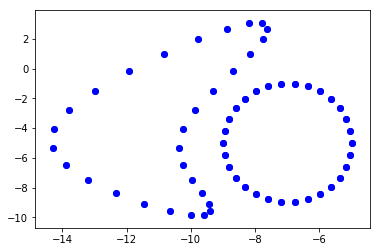

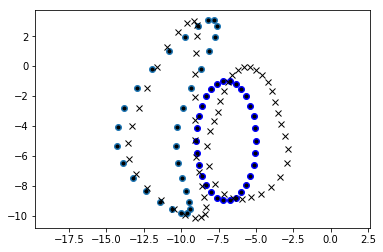

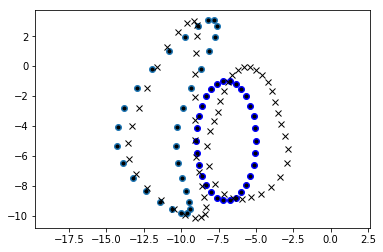

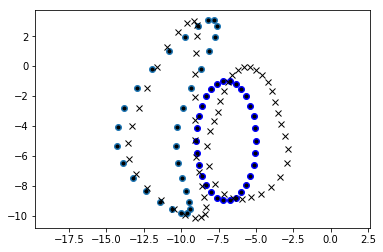

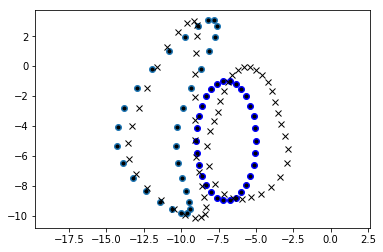

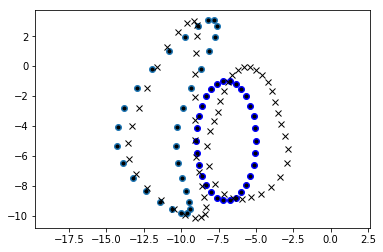

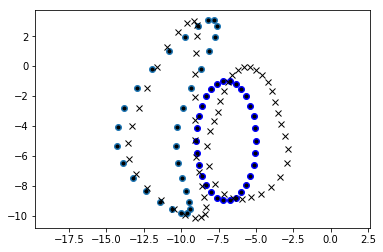

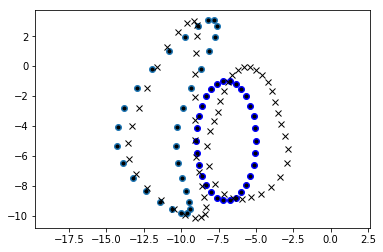

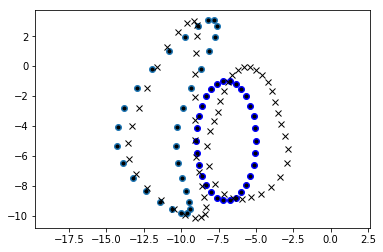

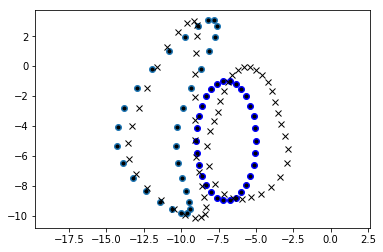

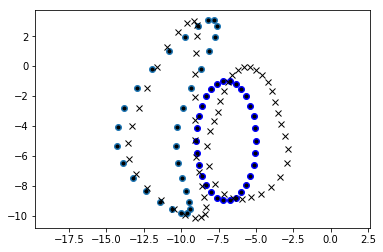

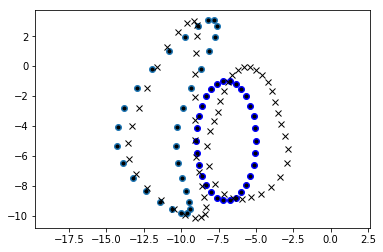

In [10]:
#%matplotlib qt5
H.module.manifold.fill_gd(gd0_tensor)
H.module.manifold.fill_cotan(torch.tensor(mom0_tensor).requires_grad_())

states, controls = dm.shooting.shoot_euler(H, it=10)

import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, len(states)))

fig_shooting = plt.figure(figsize = (10,10), dpi=100)
for s,c in zip(states, colors):
    plt.figure()
    c= 'b'
    plt.scatter(s[0][0].gd.view(-1,2)[:, 0].detach().numpy(), s[0][0].gd.view(-1,2)[:, 1].detach().numpy())
    plt.scatter(s[1][0].gd.view(-1,2)[:, 0].detach().numpy(), s[1][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][0].gd.view(-1,2)[:, 0].detach().numpy(), s[2][0].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    #plt.scatter(s[2][1].gd.view(-1,2)[:, 0].detach().numpy(), s[2][1].gd.view(-1,2)[:, 1].detach().numpy(), c=c)
    plt.plot(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), 'xk')
    plt.plot(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), 'xk')

    plt.plot(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), '.k')
    plt.plot(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), '.k')

    
    plt.axis('equal')
    plt.show(fig_shooting)

In [11]:
def fun(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.energy_tensor(gd0_tensor, Y).detach().numpy()[0]

In [12]:
def jac(P):
    #EnergyFunctional = args[0]
    Y = torch.tensor(P).requires_grad_()
    return EnergyFunctional.gradE_autograd(gd0_tensor, Y).detach().numpy()

In [13]:
import scipy

In [14]:
args = [EnergyFunctional]

In [15]:
P = mom0_tensor.detach().numpy()

In [17]:
res = scipy.optimize.minimize(fun, mom0_tensor.detach().numpy(),
                              method='BFGS',
                              jac=jac,
                              bounds=None,
                              tol=None,
                              callback=None,
                              options={
                                  'maxcor': 10,
                                  'ftol': 1.e-09,
                                  'gtol': 1e-03,
                                  'eps': 1e-08,
                                  'maxfun': 500,
                                  'maxiter': 100,
                                  'iprint': 1,
                                  'maxls': 25
                              })

/home/rosa/.local/share/miniconda2/envs/py3projects/lib/python3.6/site-packages/ipykernel_launcher.py:15: OptimizeWarning: Unknown solver options: maxcor, ftol, maxfun, iprint, maxls
  from ipykernel import kernelapp as app


cost: [ 0.] attach: 16.183242198688024
cost: [ 0.] attach: 16.183242198688024
cost: [ 0.00272176] attach: 13.235076243484016
cost: [ 0.00272176] attach: 13.235076243484016
cost: [ 0.06948477] attach: 13.361553265410757
cost: [ 0.06948477] attach: 13.361553265410757
cost: [ 0.02638655] attach: 9.263060646232015
cost: [ 0.02638655] attach: 9.263060646232015
cost: [ 0.02229848] attach: 8.850112580383993
cost: [ 0.02229848] attach: 8.850112580383993
cost: [ 0.02962981] attach: 8.009652380499784
cost: [ 0.02962981] attach: 8.009652380499784
cost: [ 0.10092794] attach: 4.854572661465172
cost: [ 0.10092794] attach: 4.854572661465172
cost: [ 0.43822369] attach: 9.199721313162339
cost: [ 0.43822369] attach: 9.199721313162339
cost: [ 0.18351356] attach: 3.9333299524394807
cost: [ 0.18351356] attach: 3.9333299524394807
cost: [ 0.16092561] attach: 3.3702389885271473
cost: [ 0.16092561] attach: 3.3702389885271473
cost: [ 0.1763716] attach: 3.2828076813455453
cost: [ 0.1763716] attach: 3.28280768134

In [18]:
mom_tensor = res.x

In [24]:
modules.module_list[2].module_list

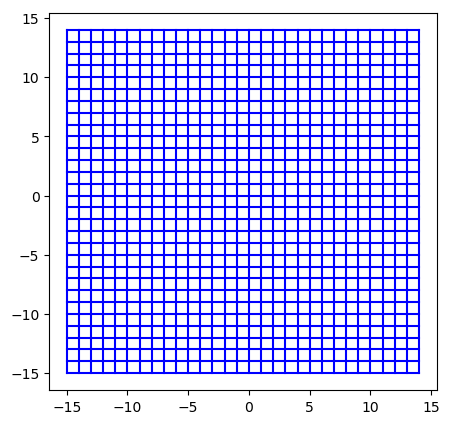

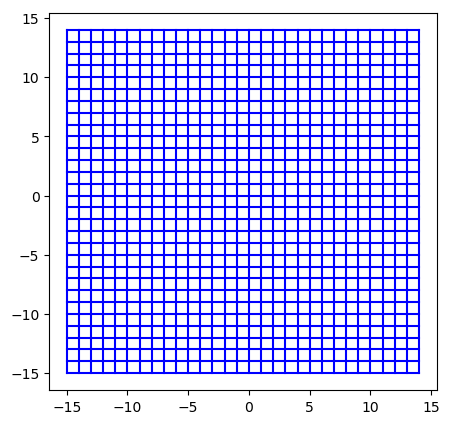

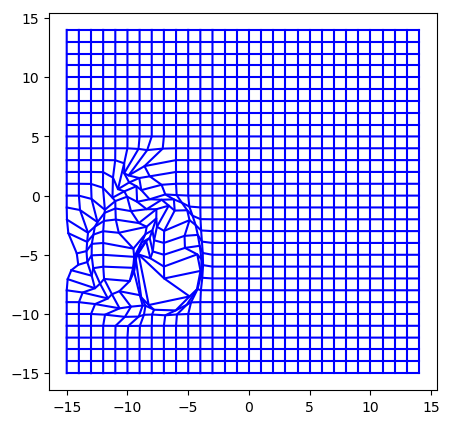

In [20]:
# Visualization of grid deformation for each submodule
nx, ny = 30, 30
sx, sy = 30, 30
x, y = torch.meshgrid([torch.arange(0, nx), torch.arange(0, ny)])
x = sx*(x.type(torch.DoubleTensor)/nx - 0.5)
y = sy*(y.type(torch.DoubleTensor)/ny - 0.5)

gridpoints = dm.usefulfunctions.grid2vec(x, y).type(torch.DoubleTensor)


phi = mm.largeDeformation(modules, states, controls, gridpoints)
x1, y1 = dm.usefulfunctions.vec2grid(phi[0], nx, ny)
x2, y2 = dm.usefulfunctions.vec2grid(phi[1], nx, ny)
x3, y3 = dm.usefulfunctions.vec2grid(phi[2], nx, ny)



fig_grid1 = mm.plot_grid( x1.detach().numpy(), y1.detach().numpy(), color = 'blue')
fig_grid2 = mm.plot_grid(x2.detach().numpy(), y2.detach().numpy(), color = 'blue')
fig_grid_bg = mm.plot_grid( x3.detach().numpy(), y3.detach().numpy(), color = 'blue')
plt.show()


In [ ]:
fig_shooting.savefig('results/movingOrgans/shooting.png')
fig_source.savefig('results/movingOrgans/source.png')
fig_target.savefig('results/movingOrgans/target.png')

fig_grid1.savefig('results/movingOrgans/grid1.png')
fig_grid2.savefig('results/movingOrgans/grid2.png')
fig_grid_bg.savefig('results/movingOrgans/grid_bg.png')

In [ ]:
def test_gradcheck_Hamiltonian():
    def hamiltonian(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.geodesic_controls()
                
        return H()
    return torch.autograd.gradcheck(hamiltonian, (gd, mom), rais\gride_exception=True)

gd = gd0_tensor
mom = 1000*torch.rand(mom0_tensor.shape)


test_gradcheck_Hamiltonian()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):

        return model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param).energy_tensor(gd, mom)
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = gd0_tensor
mom = mom0_tensor


test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_shooting():
    def shooting(gd, mom):
        
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        
        intermediate_states, intermediate_controls = dm.shooting.shoot_euler(H, it=2)
        return H.module.manifold.unroll_cotan()
    return torch.autograd.gradcheck(shooting, (gd, mom), raise_exception=True,atol=1e-2)

test_gradcheck_shooting()

In [ ]:
def test_gradcheck_attachement():
    def attach(gd, mom):
        reg_param = 10**-3 

        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        energyfunc = model.EnergyFunctional(H.module, H, constr_Id,source, target, 2, reg_param)

        return energyfunc.attach() 
    return torch.autograd.gradcheck(attach, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_attachement()

In [ ]:
def test_gradcheck_EnergyFunctional():
    def energy(gd, mom):
        H.module.manifold.fill_gd(gd)
        H.module.manifold.fill_cotan(mom)
        H.module.compute_geodesic_variables(constr_Id)
        return H.module.controls[0]
    return torch.autograd.gradcheck(energy, (gd, mom), raise_exception=True)

gd = torch.cat(H.module.manifold.unroll_gd(),0).requires_grad_().view(-1)
mom = torch.cat(H.module.manifold.unroll_cotan(),0).requires_grad_().view(-1)

test_gradcheck_EnergyFunctional()

In [ ]:
def test_gradcheck_autoaction():
    def autoaction(gd, mom):
        mod.manifold.fill_gd(gd)
        mod.manifold.fill_cotan(mom)
        return mod.autoaction()
    return torch.autograd.gradcheck(autoaction, (gd, mom), raise_exception=True)

mod = data.modules[0].copy()
gd = torch.cat(mod.manifold.gd.copy())
mom = torch.cat(mod.manifold.cotan.copy())

gd.requires_grad
mom.requires_grad

test_gradcheck_autoaction()